> cuDNN 오류해결?

In [2]:
# import tensorflow as tf 
 
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     # 텐서플로가 세 번째 GPU만 사용하도록 제한
#     try:
#         tf.config.experimental.set_visible_devices(gpus[5], 'GPU')
#     except RuntimeError as e:
#         # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
#         print(e)

In [1]:
import os # 위에껄로 대체가능
os.environ["CUDA_DEVICE_ORDER"]='PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
from tensorflow.python.client import device_lib


device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11304472305965390561,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 31594145408
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12003164023120331230
 physical_device_desc: "device: 0, name: NVIDIA Tesla V100-SXM2-32GB, pci bus id: 0000:07:00.0, compute capability: 7.0"]

In [4]:
import tensorflow as tf

In [5]:
print(tf.__version__)

2.4.1


In [8]:
# # #싱글지피유인데 오류가뜬다면?

# # gpus = tf.config.experimental.lis
# t_physical_devices('GPU')
# # if gpus:
# #     try:
# #         # Currently, memory growth needs to be the same across GPUs
# #         for gpu in gpus:
# #             tf.config.experimental.set_memory_growth(gpu, True)
# #         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
# #         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
# #     except RuntimeError as e:
# #         # Memory growth must be set before GPUs have been initialized
# #         print(e)

# 기타 퍼스널 함수


In [9]:
def batch_to_numpy(train_ds, test_ds):

    # av dataset
    # 0610 : 9개의 클래스에 대해 train(!0000), test(3000)
    x_train_base=np.zeros([90000, 32, 32, 3])
    y_train_base=np.zeros([90000, 1])
    x_test_base=np.zeros([27000, 32, 32, 3])
    y_test_base=np.zeros([27000, 1])

    numpy_iter=list(train_ds.as_numpy_iterator())

    for idx, batch in enumerate(numpy_iter):
    #     if idx%30==0:
    #         print(idx)
        x_train_base[128*idx:128*(idx+1), :, :, :]=batch[0]
        y_train_base[128*idx:128*(idx+1), 0]=batch[1]

    numpy_iter_test=list(test_ds.as_numpy_iterator())

    len(numpy_iter_test)

    for idx, batch in enumerate(numpy_iter_test):
    #     if idx%30==0:
    #         print(idx)
        x_test_base[128*idx:128*(idx+1), :, :, :]=batch[0]
        y_test_base[128*idx:128*(idx+1), 0]=batch[1]
    
    return x_train_base, y_train_base, x_test_base, y_test_base

In [10]:
def get_dataset():
    train_dir='../BDD100K_MOT2020_image/bdd100k/images/track/final_train_av'
    test_dir='../BDD100K_MOT2020_image/bdd100k/images/track/final_test_av'

    batch_size = 128
    img_height = 32
    img_width = 32

    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
      train_dir,
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)

    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
      test_dir,
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)
    
    return train_ds, test_ds

# Resnet

In [14]:
"""Trains a ResNet on the CIFAR10 dataset.
ResNet v1
[a] Deep Residual Learning for Image Recognition
https://arxiv.org/pdf/1512.03385.pdf
ResNet v2
[b] Identity Mappings in Deep Residual Networks
https://arxiv.org/pdf/1603.05027.pdf

"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input
from tensorflow.keras.layers import Flatten, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10 # 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
import math

# training parameters
batch_size = 128 # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = False # 0610 - pytorch와 통합
num_classes = 9 # 0604, 0610 - (9개)

# subtracting pixel mean improves accuracy
subtract_pixel_mean = False #0616 False)

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 7 # --  REsnet 44

# model version
# orig paper: version = 1 (ResNet v1), 
# improved ResNet: version = 2 (ResNet v2)
version = 1

# computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# load the CIFAR10 data.
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()

> Trainset load

In [16]:
x_train=np.load('x_train.npy')
x_test=np.load('x_test.npy')
y_train=np.load('y_train.npy')
y_test=np.load('y_test.npy')

In [12]:
# train_ds, test_ds=get_dataset() # 0604
# x_train, y_train, x_test, y_test=batch_to_numpy(train_ds, test_ds) #0604

Found 90000 files belonging to 9 classes.
Found 27000 files belonging to 9 classes.


KeyboardInterrupt: 

In [17]:
# input image dimensions.
input_shape = x_train.shape[1:]
print('input_shape : ', input_shape)
# normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
y_train=y_train.astype('uint8')
y_test=y_test.astype('uint8')
# if subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

input_shape :  (32, 32, 3)
x_train shape: (90000, 32, 32, 3)
90000 train samples
27000 test samples
y_train shape: (90000, 1)


In [18]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    Arguments:
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    Returns:
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=num_classes):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved
    (downsampled) by a convolutional layer with strides=2, while 
    the number of filters is doubled. Within each stage, 
    the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    Arguments:
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    Returns:
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, in [a])')
    # start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            # first layer but not first stack
            if stack > 0 and res_block == 0:
                # linear projection residual shortcut
                # connection to match changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [19]:
model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)), #0610 변경 lr -> leraning_Rate
              metrics=['acc'])

model.summary()

Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
________________________________________________________________________

In [ ]:
# enable this if pydot can be installed
# pip install pydot
#plot_model(model, to_file="%s.png" % model_type, show_shapes=True)
print(model_type)

# prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'save_models')
model_name = 'av11_%s_model_no_mean.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=False)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # this will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False)

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    steps_per_epoch =  math.ceil(len(x_train) / batch_size)
    # fit the model on the batches generated by datagen.flow().
    model.fit(x=datagen.flow(x_train, y_train, batch_size=batch_size),
              verbose=1,
              epochs=epochs,
              validation_data=(x_test, y_test),
              steps_per_epoch=steps_per_epoch,
              callbacks=callbacks)

ResNet44v1
Not using data augmentation.
Epoch 1/200
Learning rate:  0.001
704/704 [==============================] - 50s 52ms/step - loss: 2.0684 - acc: 0.3757 - val_loss: 2.2026 - val_acc: 0.3649

Epoch 00001: saving model to /home/jrkim/jsp/AdversarialExample/other_explain_model/save_models/av11_ResNet44v1_model_no_mean.001.h5
Epoch 2/200
Learning rate:  0.001
704/704 [==============================] - 35s 49ms/step - loss: 1.4834 - acc: 0.5861 - val_loss: 1.5869 - val_acc: 0.5457

Epoch 00002: saving model to /home/jrkim/jsp/AdversarialExample/other_explain_model/save_models/av11_ResNet44v1_model_no_mean.002.h5
Epoch 3/200
Learning rate:  0.001
704/704 [==============================] - 35s 50ms/step - loss: 1.2703 - acc: 0.6598 - val_loss: 1.6084 - val_acc: 0.5704

Epoch 00003: saving model to /home/jrkim/jsp/AdversarialExample/other_explain_model/save_models/av11_ResNet44v1_model_no_mean.003.h5
Epoch 4/200
Learning rate:  0.001
704/704 [==============================] - 35s 49ms/s

Epoch 30/200
Learning rate:  0.001
704/704 [==============================] - 36s 51ms/step - loss: 0.5694 - acc: 0.9376 - val_loss: 1.8014 - val_acc: 0.6786

Epoch 00030: saving model to /home/jrkim/jsp/AdversarialExample/other_explain_model/save_models/av11_ResNet44v1_model_no_mean.030.h5
Epoch 31/200
Learning rate:  0.001
704/704 [==============================] - 35s 49ms/step - loss: 0.5741 - acc: 0.9371 - val_loss: 1.8443 - val_acc: 0.6800

Epoch 00031: saving model to /home/jrkim/jsp/AdversarialExample/other_explain_model/save_models/av11_ResNet44v1_model_no_mean.031.h5
Epoch 32/200
Learning rate:  0.001
704/704 [==============================] - 35s 50ms/step - loss: 0.5626 - acc: 0.9409 - val_loss: 2.0267 - val_acc: 0.6606

Epoch 00032: saving model to /home/jrkim/jsp/AdversarialExample/other_explain_model/save_models/av11_ResNet44v1_model_no_mean.032.h5
Epoch 33/200
Learning rate:  0.001
704/704 [==============================] - 34s 48ms/step - loss: 0.5656 - acc: 0.9428 - v

704/704 [==============================] - 34s 49ms/step - loss: 0.5403 - acc: 0.9481 - val_loss: 1.9410 - val_acc: 0.6740

Epoch 00058: saving model to /home/jrkim/jsp/AdversarialExample/other_explain_model/save_models/av11_ResNet44v1_model_no_mean.058.h5
Epoch 59/200
Learning rate:  0.001
704/704 [==============================] - 34s 49ms/step - loss: 0.5232 - acc: 0.9549 - val_loss: 1.7876 - val_acc: 0.6931

Epoch 00059: saving model to /home/jrkim/jsp/AdversarialExample/other_explain_model/save_models/av11_ResNet44v1_model_no_mean.059.h5
Epoch 60/200
Learning rate:  0.001
704/704 [==============================] - 35s 49ms/step - loss: 0.5403 - acc: 0.9481 - val_loss: 2.4364 - val_acc: 0.6350

Epoch 00060: saving model to /home/jrkim/jsp/AdversarialExample/other_explain_model/save_models/av11_ResNet44v1_model_no_mean.060.h5
Epoch 61/200
Learning rate:  0.001
704/704 [==============================] - 34s 49ms/step - loss: 0.5242 - acc: 0.9543 - val_loss: 2.0781 - val_acc: 0.6653



704/704 [==============================] - 35s 49ms/step - loss: 0.3586 - acc: 0.9997 - val_loss: 1.5283 - val_acc: 0.7690

Epoch 00086: saving model to /home/jrkim/jsp/AdversarialExample/other_explain_model/save_models/av11_ResNet44v1_model_no_mean.086.h5
Epoch 87/200
Learning rate:  0.0001
704/704 [==============================] - 35s 50ms/step - loss: 0.3433 - acc: 0.9999 - val_loss: 1.5712 - val_acc: 0.7660

Epoch 00087: saving model to /home/jrkim/jsp/AdversarialExample/other_explain_model/save_models/av11_ResNet44v1_model_no_mean.087.h5
Epoch 88/200
Learning rate:  0.0001
704/704 [==============================] - 35s 50ms/step - loss: 0.3271 - acc: 0.9999 - val_loss: 1.5620 - val_acc: 0.7687

Epoch 00088: saving model to /home/jrkim/jsp/AdversarialExample/other_explain_model/save_models/av11_ResNet44v1_model_no_mean.088.h5
Epoch 89/200
Learning rate:  0.0001
704/704 [==============================] - 35s 50ms/step - loss: 0.3102 - acc: 0.9997 - val_loss: 1.5812 - val_acc: 0.767

704/704 [==============================] - 35s 50ms/step - loss: 0.1470 - acc: 0.9996 - val_loss: 1.8119 - val_acc: 0.7620

Epoch 00114: saving model to /home/jrkim/jsp/AdversarialExample/other_explain_model/save_models/av11_ResNet44v1_model_no_mean.114.h5
Epoch 115/200
Learning rate:  0.0001
704/704 [==============================] - 35s 50ms/step - loss: 0.1503 - acc: 0.9981 - val_loss: 1.8571 - val_acc: 0.7572

Epoch 00115: saving model to /home/jrkim/jsp/AdversarialExample/other_explain_model/save_models/av11_ResNet44v1_model_no_mean.115.h5
Epoch 116/200
Learning rate:  0.0001
704/704 [==============================] - 36s 51ms/step - loss: 0.1431 - acc: 0.9995 - val_loss: 1.8611 - val_acc: 0.7547

Epoch 00116: saving model to /home/jrkim/jsp/AdversarialExample/other_explain_model/save_models/av11_ResNet44v1_model_no_mean.116.h5
Epoch 117/200
Learning rate:  0.0001
704/704 [==============================] - 35s 50ms/step - loss: 0.1409 - acc: 0.9995 - val_loss: 1.9127 - val_acc: 0.

In [14]:
# score trained model
scores = model.evaluate(x_test,
                        y_test,
                        batch_size=batch_size,
                        verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
________________________________________________________________________

Epoch 1/200
Learning rate:  0.001
704/704 [==============================] - 49s 50ms/step - loss: 2.1877 - acc: 0.3543 - val_loss: 1.8185 - val_acc: 0.4618

Epoch 00001: val_acc improved from -inf to 0.46178, saving model to /home/jrkim/jsp/AdversarialExample/other_explain_model/save_models/av11_ResNet44v1_model.001.h5
Epoch 2/200
Learning rate:  0.001
704/704 [==============================] - 31s 44ms/step - loss: 1.5064 - acc: 0.5807 - val_loss: 1.6276 - val_acc: 0.5500

Epoch 00002: val_acc improved from 0.46178 to 0.55000, saving model to /home/jrkim/jsp/AdversarialExample/other_explain_model/save_models/av11_ResNet44v1_model.002.h5
Epoch 3/200
Learning rate:  0.001
704/704 [==============================] - 31s 45ms/step - loss: 1.2956 - acc: 0.6545 - val_loss: 1.6838 - val_acc: 0.5357

Epoch 00003: val_acc did not improve from 0.55000
Epoch 4/200
Learning rate:  0.001
704/704 [==============================] - 33s 46ms/step - loss: 1.1551 - acc: 0.7021 - val_loss: 1.6083 - val_

KeyboardInterrupt: 

### 오류해결

>cifar10 path

In [113]:
(x_train2, y_train2), (x_test2, y_test2) = cifar10.load_data()

In [112]:
x_train.shape

(50000, 32, 32, 3)

In [116]:
# input image dimensions.
input_shape = x_train2.shape[1:]
print('input_shape : ', input_shape)
# normalize data.
x_train2 = x_train2.astype('float32') / 255
x_test2 = x_test2.astype('float32') / 255

# if subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train2_mean = np.mean(x_train2, axis=0)
    x_train2 -= x_train2_mean
    x_test2 -= x_train2_mean

print('x_train2 shape:', x_train2.shape)
print(x_train2.shape[0], 'train2 samples')
print(x_test2.shape[0], 'test2 samples')
print('y_train2 shape:', y_train2.shape)

# convert class vectors to binary class matrices.
y_train2 = to_categorical(y_train2, num_classes)
y_test2 = to_categorical(y_test2, num_classes)

input_shape :  (32, 32, 3)
x_train2 shape: (50000, 32, 32, 3)
50000 train2 samples
10000 test2 samples
y_train2 shape: (50000, 1)


In [120]:
y_test.shape

(31495, 11)

In [115]:
# input image dimensions.
input_shape = x_train.shape[1:]
print('input_shape : ', input_shape)
# normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# if subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

input_shape :  (32, 32, 3)
x_train shape: (133641, 32, 32, 3)
133641 train samples
31495 test samples
y_train shape: (133641, 1)


## 수정 함수

In [7]:
import tensorflow as tf
import tensorflow_datasets as tfds

ModuleNotFoundError: No module named 'tensorflow_datasets'

In [2]:
def get_dataset():
    train_dir='../BDD100K_MOT2020_image/bdd100k/images/track/final_train_av'
    test_dir='../BDD100K_MOT2020_image/bdd100k/images/track/final_test_av'

    batch_size = 128
    img_height = 32
    img_width = 32

    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
      train_dir,
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)

    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
      test_dir,
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)
    
    return train_ds, test_ds

In [2]:
def get_dataset():
    train_dir='../BDD100K_MOT2020_image/bdd100k/images/track/final_train_av'
    test_dir='../BDD100K_MOT2020_image/bdd100k/images/track/final_test_av'

    batch_size = 128
    img_height = 32
    img_width = 32

    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
      train_dir,
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)

    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
      test_dir,
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)
    
    return train_ds, test_ds

In [13]:
train_ds, test_ds=get_dataset()

Found 10000 files belonging to 10 classes.
Found 3000 files belonging to 10 classes.


In [15]:
class_names = test_ds.class_names
print(class_names)

['.ipynb_checkpoints', 'bicycle', 'bus', 'car', 'motorcycle', 'other person', 'other vehicle', 'pedestrian', 'rider', 'truck']


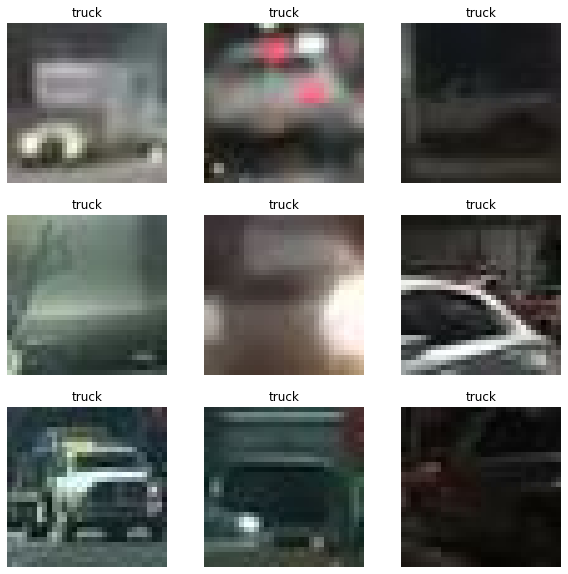

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Batchdataset to numpy  
133641
31495

In [16]:
train_ds.classes

AttributeError: 'BatchDataset' object has no attribute 'classes'

In [15]:
help(train_ds)

Help on BatchDataset in module tensorflow.python.data.ops.dataset_ops object:

class BatchDataset(UnaryDataset)
 |  A `Dataset` that batches contiguous elements from its input.
 |  
 |  Method resolution order:
 |      BatchDataset
 |      UnaryDataset
 |      DatasetV2
 |      collections.abc.Iterable
 |      tensorflow.python.training.tracking.base.Trackable
 |      tensorflow.python.framework.composite_tensor.CompositeTensor
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, input_dataset, batch_size, drop_remainder)
 |      See `Dataset.batch()` for details.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  element_spec
 |      The type specification of an element of this dataset.
 |      
 |      >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
 |      >>> dataset.element_spec
 |      TensorSpec(shape=(), dtype=tf.int32, name=None)
 |      
 |      For more information,

In [1]:
def batch_to_numpy(train_ds, test_ds):

    # av dataset
    # 0610 : 9개의 클래스에 대해 train(!0000), test(3000)
    x_train_base=np.zeros([90000, 32, 32, 3])
    y_train_base=np.zeros([90000, 1])
    x_test_base=np.zeros([27000, 32, 32, 3])
    y_test_base=np.zeros([27000, 1])

    numpy_iter=list(train_ds.as_numpy_iterator())

    for idx, batch in enumerate(numpy_iter):
    #     if idx%30==0:
    #         print(idx)
        x_train_base[128*idx:128*(idx+1), :, :, :]=batch[0]
        y_train_base[128*idx:128*(idx+1), 0]=batch[1]

    numpy_iter_test=list(test_ds.as_numpy_iterator())

    len(numpy_iter_test)

    for idx, batch in enumerate(numpy_iter_test):
    #     if idx%30==0:
    #         print(idx)
        x_test_base[128*idx:128*(idx+1), :, :, :]=batch[0]
        y_test_base[128*idx:128*(idx+1), 0]=batch[1]
    
    return x_train_base, y_train_base, x_test_base, y_test_base